Number of Omega-automaton states (including the trap state): 5
Number of accepting pairs: 2


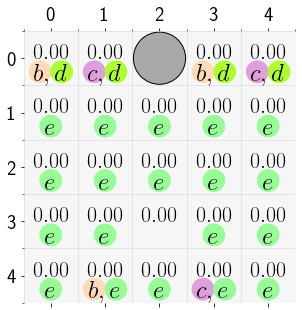

In [1]:
%matplotlib inline
from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np
import pickle

# Specification
ltl = 'G F b & G F c & (F G d | F G e)'
oa = OmegaAutomaton(ltl,oa_type='dra')
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])
print('Number of accepting pairs:',oa.shape[0])
display(oa)

# MDP Description
shape = (5,5)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
    ['E',  'E',  'B',  'E',  'E'],
    ['E',  'E',  'E',  'E',  'E'],
    ['E',  'E',  'E',  'E',  'E'],
    ['E',  'E',  'E',  'E',  'E'],
    ['E',  'E',  'E',  'E',  'E']
])

label = np.array([
    [('b','d'), ('c','d'), (),     ('b','d'), ('c','d')],
    [('e',),    ('e',),    ('e',), ('e',),    ('e',)],
    [('e',),    ('e',),    ('e',), ('e',),    ('e',)],
    [('e',),    ('e',),    (),     ('e',),    ('e',)],
    [('e',),    ('b','e'), ('e',), ('c','e'), ('e',)]
],dtype=np.object)

reward = np.zeros(shape)

lcmap={
    'b':'peachpuff',
    'c':'plum',
    'd':'greenyellow',
    'e':'palegreen'
}

grid_mdp = GridMDP(shape=shape,structure=structure,reward=reward,label=label,figsize=5,robust=True,lcmap=lcmap)  # Use figsize=4 for smaller figures
grid_mdp.plot()
# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)

In [2]:
# Q=csrl.minimax_q(T=2**10,K=2**20)
Q = np.load('robust_Q.npy')
with open('robust_csrl.pkl','rb') as f:
    csrl = pickle.load(f)

In [3]:
# Calculate the policy
policy = np.argmax(np.min(Q,axis=-1),axis=-1)
policy_ = np.take_along_axis(np.argmin(Q,axis=-1),np.expand_dims(policy,axis=-1),axis=-1).reshape(policy.shape)

value = np.max(np.min(Q,axis=-1),axis=-1)
_value = np.copy(value)
_policy = np.copy(policy)
_value[:] = np.max(value,axis=0)
_policy[:] = np.argmax(value,axis=0)

ind = (csrl.discountC*_value) > value
policy[ind] = _policy[ind] + len(csrl.mdp.A)
csrl.plot(value=value,policy=policy,policy_=policy_)

interactive(children=(IntSlider(value=0, description='i', max=1), IntSlider(value=0, description='q', max=4), …

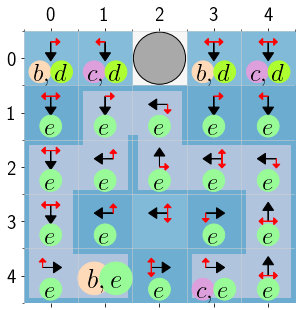

In [4]:
path = {
    (4,3) : 'r',
    (4,4) : 'lu',
    (3,4) : 'du',
    (2,4) : 'dl',
    (2,3) : 'rl',
    (2,2) : 'ru',
    (1,2) : 'dl',
    (1,1) : 'rd',
    (2,1) : 'ul',
    (2,0) : 'rd',
    (3,0) : 'ud',
    (4,0) : 'ur',
    (4,1) : 'l'
}
hidden=[(4,1)]
csrl.plot(value=value,policy=policy,policy_=policy_,iq=(1,3),path=path,hidden=hidden,save='robust_controller_c_to_b.pdf')

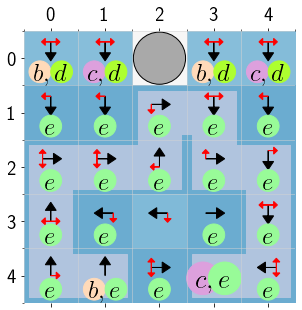

In [5]:
path = {
    (4,1) : 'l',
    (4,0) : 'ru',
    (3,0) : 'du',
    (2,0) : 'dr',
    (2,1) : 'lr',
    (2,2) : 'lu',
    (1,2) : 'dr',
    (1,3) : 'ld',
    (2,3) : 'ur',
    (2,4) : 'ld',
    (3,4) : 'ud',
    (4,4) : 'ul',
    (4,3) : 'r'
}
hidden=[(4,3)]
csrl.plot(value=value,policy=policy,policy_=policy_,iq=(1,2),path=path,hidden=hidden,save='robust_controller_b_to_c.pdf')

In [6]:
episode=csrl.simulate(policy,policy_,value=value,start=(3,2),T=100,animation='test')

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

In [11]:
# np.save('robust_episode',np.array(episode))
import os
import matplotlib.pyplot as plt
pad=5
animation='robust'
T=100
if not os.path.exists(animation):
    os.makedirs(animation)
for t in range(T):
    csrl.mdp.plot(value=value[episode[t][:2]],policy=policy[episode[t][:2]],policy_=policy_[episode[t][:2]],agent=episode[t][2:],save=animation+os.sep+str(t).zfill(pad)+'.png',title='Time: '+str(t)+',  Accepting Pair: '+str(episode[t][0]+1)+',  DRA State (Mode): '+str(episode[t][1]))
    plt.close()
os.system('ffmpeg -r 3 -i '+animation+os.sep+'%0'+str(pad)+'d.png -vcodec libx264 -y '+animation+'.mp4')

0